In [8]:
import pandas as pd 
import anndata as ad 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
from scipy.stats import pearsonr
from mygene import MyGeneInfo
from matplotlib_venn import venn3
from upsetplot import from_contents, UpSet 

In [9]:
## LOAD SPECIFICITY MATRIX DATA: (AT THE CLUSTER ID LEVEL)

genome = "NCBI37" #"NCBI38"

exp_conti_spe = pd.read_csv (f"/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Alma/data/newest_BG/{genome}/conti_specificity_matrix.txt", 
                             sep =r"\s+", engine = "python")

exp_conti_spe.set_index("ENTREZ", inplace=True)

In [10]:
## LOAD THE EQUIVALENT WITH GROUPS AND CLASSES: 
    # Excel File with all annotations for the Basal ganglia Cell Atlas: 

sheet_id = "12XOtSJnZruEkfrqHlN37L2XAaxnYLrpuAJwfz-JSjR8"
gid = "1145771741"  # C’est l’onglet spécifique
url_csv = f"https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv&gid={gid}"

annotations_df = pd.read_csv(url_csv)
annotations_df = annotations_df[["cluster_id", "Neighborhood", "Class", "Subclass",
                                  "Silettisub_MapMyCells_Subcluster_label", "Silettisub_MapMyCells_Cluster_label",
                                  "Anatomical_region"]]


In [11]:
## LOAD PHENOTYPES' SPECIFIC ASSOCIATIONS AND KEEP THE GENES WITH THE HIGHEST ASSOCIATIONS:

# Function to load and merge gene stats with expression specificity
def load_and_merge_stats(file_path, exp_df, gene_col="GENE", stat_col="ZSTAT", top_n=1000):
    stats_df = pd.read_csv(file_path, sep=r"\s+", engine="python")
    merged_df = pd.merge(exp_df, stats_df, left_index=True, right_on=gene_col)
    top_genes = merged_df.sort_values(by=stat_col, ascending=False).head(top_n)
    return top_genes

# File paths
file_paths = {
    "SCZ": "/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Alma/SCZ_2022_automated_new/european/PGC3_SCZ_wave3.european.autosome.public.v3.vcf.tsv_no_heading.step2.genes.out",
    "MDD": "/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Alma/depression_automated_new/european/pgc-mdd2025_no23andMe_eur_v3-49-24-11.tsv_no_heading.step2.genes.out",
    "BD":  "/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Alma/bipolar_disorder_automated_new/european/bip2024_eur_no23andMe.tsv_no_heading.step2.genes.out"
}

# Load top 1000 genes per phenotype
top_genes = {
    pheno: load_and_merge_stats(path, exp_conti_spe)
    for pheno, path in file_paths.items()
}

/home/alma.dubuc/miniconda3/envs/python_env/lib/python3.10/site-packages/upsetplot/data.py:385: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)
/home/alma.dubuc/miniconda3/envs/python_env/lib/python3.10/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original objec

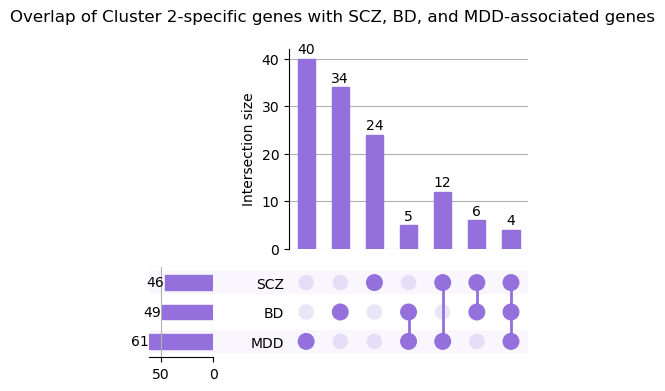

In [12]:
## CLUSTER 2 ASSOCIATIONS ACROSS ALL PHENOTYPES:

## Set of Cluster 2-specific genes:
cluster = "Cluster_2"
cluster_specificity_2 = exp_conti_spe[[cluster]]

threshold_2 = cluster_specificity_2[cluster].quantile(0.95)
top_genes_2 = cluster_specificity_2[cluster_specificity_2[cluster] >= threshold_2].sort_values(by=cluster, ascending=False)

cluster2_specific_genes = set(top_genes_2.index)

## Overlap with genes associated to the different traits:
venn_sets_cluster2 = {
    pheno: cluster2_specific_genes & set(top_genes[pheno]["GENE"])
    for pheno in top_genes
}


## Upset Plot
upset_data_cluster2 = from_contents(venn_sets_cluster2)

UpSet(upset_data_cluster2, subset_size='count', show_counts=True,
      facecolor="mediumpurple", orientation="horizontal").plot()

plt.suptitle("Overlap of Cluster 2-specific genes with SCZ, BD, and MDD-associated genes")
plt.show()

In [13]:
## WHO ARE THOSE COMMON GENES:

## Intersections with two phenotypes 
pairwise_intersections = {
    "SCZ ∩ BD": set(top_genes["SCZ"]["GENE"]) & set(top_genes["BD"]["GENE"]) & cluster2_specific_genes,
    "SCZ ∩ MDD": set(top_genes["SCZ"]["GENE"]) & set(top_genes["MDD"]["GENE"]) & cluster2_specific_genes,
    "BD ∩ MDD":  set(top_genes["BD"]["GENE"]) & set(top_genes["MDD"]["GENE"]) & cluster2_specific_genes
}

triple_intersection = (
    set(top_genes["SCZ"]["GENE"]) &
    set(top_genes["BD"]["GENE"]) &
    set(top_genes["MDD"]["GENE"]) &
    cluster2_specific_genes
)


# All genes to annotate
all_entrez_ids = set().union(*pairwise_intersections.values())

mg = MyGeneInfo()

all_genes_to_annotate = set().union(*pairwise_intersections.values())
results = mg.querymany(list(all_genes_to_annotate), scopes='entrezgene', fields='symbol,name', species='human')

id_to_symbol = {
    str(r["query"]): r.get("symbol", f"(no symbol for {r['query']})")
    for r in results if not r.get("notfound", False)
}
for r in results:
    if r.get("notfound", False):
        id_to_symbol[str(r["query"])] = f"(unmapped:{r['query']})"

for label, gene_set in pairwise_intersections.items():
    symbols = [id_to_symbol.get(str(g), str(g)) for g in gene_set]
    print(f"{label} ({len(symbols)} genes):")
    print(", ".join(symbols))

querying 1-27...done.
Finished.
SCZ ∩ BD (10 genes):
BCL11B, YJEFN3, ZNF804A, KCNG1, ZNF365, RCOR2, DRD2, GRIN2A, ARPP19, DCC
SCZ ∩ MDD (16 genes):
DPYSL5, MFSD2B, CAMKV, PITPNM2, YPEL1, SP9, ZNF804A, ANKK1, SGCZ, RASGRP1, KIRREL3, RCOR2, CALN1, TRAIP, DRD2, DCC
BD ∩ MDD (9 genes):
ZNF804A, SHISA9, GPR52, RCOR2, DRD2, WIPF3, INSYN2B, ZBBX, DCC
